In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


/Users/nathanieldirenzo/opt/anaconda3/envs/engineering/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
bucket_name="ndir-metis-bucket"
path=f"gs://{bucket_name}/asteroid/processed_asteroid_data.csv"

In [3]:
df = pd.read_csv(path,
                 storage_options={"token": "secrets.json"},
                 low_memory=False)

In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)

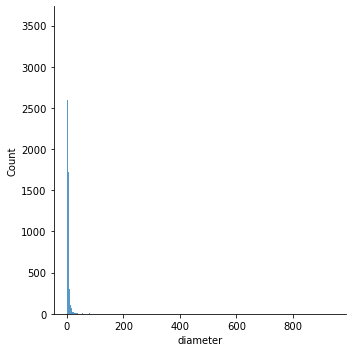

In [5]:
sns.displot(df.diameter);

In [6]:
df = df[df['diameter'] < np.quantile(df['diameter'], 0.99)]

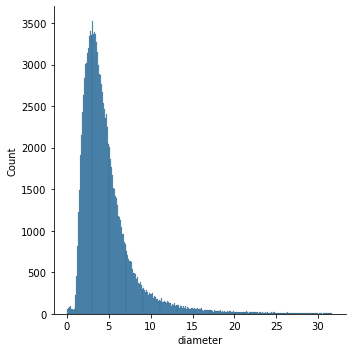

In [7]:
sns.displot(df.diameter);

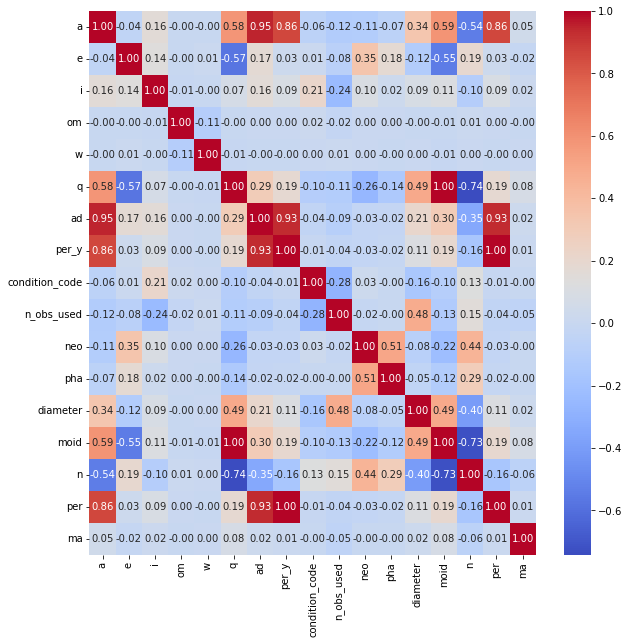

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm');

# Feature Info
- a: semi-major axis (au)
- e: eccentricity
- i: inclination with respect to ecliptic plane
- om: longitude of the ascending node
- w: argument of perihelion
- q: perihelion distance (au)
- ad: aphelion distance (au)
- per_y: orbital period (years)
- data_arc: span of recorded data (days)
- condition_code: orbital condition code
- n_obs_used: number of observations used
- H: absolute magnitude parameter
- neo: near-earth object
- pha: physically hazardous object
- diameter: diameter (target variable)
- extent: Object bi/tri axial ellipsoid dimensions(Km)
- albedo: geometric albedo
- rot_per: rotation period (hours)
- GM: gravitational parameter. Product of mass and gravitational constant
- BV: Color index B-V magnitude difference
- UB: Color index U-B magnitude difference
- IR: Color index I-R magnitude difference
- specB: Spectral taxonomic type(SMASSII)
- specT: Spectral taxonomic type (Tholen)
- G: Magnitude slope parameter
- moid: Earth minimum orbit intersection distance
- class: asteroid orbit class
- n: mean motion (degrees/day)
- per: orbital period (days)
- ma: mean ananomly (degrees)


In [9]:
final_df = df.drop(columns=['om', 'w', 'ma', 'condition_code', 'name', 'per_y'])

In [10]:
final_df = pd.get_dummies(final_df, prefix='class', columns=['class'])

In [11]:
X, y = final_df.drop('diameter',axis=1), final_df['diameter']

In [12]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=42)

In [13]:
xgr_model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=10, reg_lambda=10, reg_alpha=10, n_jobs=-1, colsample_bytree=0.3)

In [14]:
xgr_model.fit(X_train, y_train)

/Users/nathanieldirenzo/opt/anaconda3/envs/engineering/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, reg_lambda=10, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
y_val_pred = xgr_model.predict(X_val)

In [16]:
r2 = r2_score(y_val, y_val_pred)
print("R2: %.2f" % (r2))

R2: 0.79


In [17]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=10,
                       objective="reg:squarederror",  # Other options: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

/Users/nathanieldirenzo/opt/anaconda3/envs/engineering/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-rmse:5.02522	validation_1-rmse:5.04920
[1]	validation_0-rmse:4.66533	validation_1-rmse:4.69632
[2]	validation_0-rmse:4.25345	validation_1-rmse:4.29416
[3]	validation_0-rmse:3.97366	validation_1-rmse:4.02162
[4]	validation_0-rmse:3.63683	validation_1-rmse:3.69558
[5]	validation_0-rmse:3.33700	validation_1-rmse:3.40824
[6]	validation_0-rmse:3.07047	validation_1-rmse:3.15440
[7]	validation_0-rmse:2.83789	validation_1-rmse:2.93535
[8]	validation_0-rmse:2.68813	validation_1-rmse:2.79580
[9]	validation_0-rmse:2.56022	validation_1-rmse:2.67683
[10]	validation_0-rmse:2.38400	validation_1-rmse:2.51798
[11]	validation_0-rmse:2.22901	validation_1-rmse:2.37833
[12]	validation_0-rmse:2.14396	validation_1-rmse:2.30318
[13]	validation_0-rmse:2.07141	validation_1-rmse:2.24038
[14]	validation_0-rmse:2.01031	validation_1-rmse:2.18873
[15]	validation_0-rmse:1.90209	validation_1-rmse:2.09624
[16]	validation_0-rmse:1.80724	validation_1-rmse:2.01963
[17]	validation_0-rmse:1.76733	validation

In [18]:
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())

In [19]:
rmse(gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),y_test) 

/Users/nathanieldirenzo/opt/anaconda3/envs/engineering/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1.566001967720599

In [23]:
#Step by step RMSEs, with .1 learning rate:
#best max_depth: 7, .452
#best subsample: .8, .448
#best min_child_weight: 12, .446
#best colsample_bytree: .7, .444

gbm = xgb.XGBRegressor(
    n_estimators=30000,  #arbitrary large number
    max_depth=10,
    objective="reg:squarederror",
    learning_rate=.05,
    subsample=.8,
    min_child_weight=12,
    colsample_bytree=.7,
    n_jobs=-1,
    random_state=0)

eval_set = [(X_train, y_train),
            (X_val, y_val)]  #tracking train/validation error as we go
fit_model = gbm.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=False)


In [25]:
rmse(gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit), y_val)

/Users/nathanieldirenzo/opt/anaconda3/envs/engineering/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1.581921832902244

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

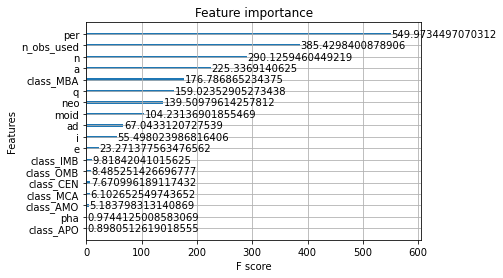

In [26]:
xgb.plot_importance(gbm, importance_type='gain')

# Feature Info
- a: semi-major axis (au)
- e: eccentricity
- i: inclination with respect to ecliptic plane
- om: longitude of the ascending node
- w: argument of perihelion
- q: perihelion distance (au)
- ad: aphelion distance (au)
- per_y: orbital period (years)
- data_arc: span of recorded data (days)
- condition_code: orbital condition code
- n_obs_used: number of observations used
- H: absolute magnitude parameter
- neo: near-earth object
- pha: physically hazardous object
- diameter: diameter (target variable)
- extent: Object bi/tri axial ellipsoid dimensions(Km)
- albedo: geometric albedo
- rot_per: rotation period (hours)
- GM: gravitational parameter. Product of mass and gravitational constant
- BV: Color index B-V magnitude difference
- UB: Color index U-B magnitude difference
- IR: Color index I-R magnitude difference
- specB: Spectral taxonomic type(SMASSII)
- specT: Spectral taxonomic type (Tholen)
- G: Magnitude slope parameter
- moid: Earth minimum orbit intersection distance
- class: asteroid orbit class
- n: mean motion (degrees/day)
- per: orbital period (days)
- ma: mean ananomly (degrees)


In [27]:
print(np.sqrt(mean_squared_error(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))

1.5375403187119223


/Users/nathanieldirenzo/opt/anaconda3/envs/engineering/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [28]:
print((r2_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))))

0.7965086847388756


/Users/nathanieldirenzo/opt/anaconda3/envs/engineering/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [30]:
final_df.to_csv('gs://ndir-metis-bucket/asteroid/final_df.csv',
                storage_options={"token": "secrets.json"})

In [31]:
gbm.save_model('xgb_model.json')